# <font size=35 color=lightgreen>** Sentiment API **<font>
---

### <font size=12 color=lightgreen>Configuración Inicial (Librerías)</font>

#### 1. Procesamiento y Manipulación de Datos
* **`pandas`**
    * Nos ayuda con la manipulación y análisis de datos estructurados.
    * Carga el dataset (CSV), gestiona el DataFrame y permite filtrar o limpiar registros.
* **`numpy`**
    * Realiza las operaciones matemáticas y manejo de arrays eficientes.
    * Soporte numérico fundamental para las transformaciones vectoriales de los textos.

#### 2. Visualización y Análisis Exploratorio

* **`matplotlib.pyplot`**
    * Generación de gráficos estáticos.
    * Visualización básica de la distribución de clases (Positivo vs. Negativo).
* **`seaborn`**
    * Visualización de datos estadísticos avanzada.
    * Generación de matrices de confusión y gráficos de distribución estéticos para la presentación.

#### 3. Procesamiento de Lenguaje Natural (NLP) y Limpieza

* **`re`** (Regular Expressions)
    * Manejo de expresiones regulares.
    * Eliminación de ruido en el texto: URLs, menciones (@usuario), hashtags (#) y caracteres especiales no alfanuméricos.
* **`string`**
    * Constantes de cadenas comunes.
    * Provee listas estándar de signos de puntuación para su eliminación eficiente.

#### 4. Modelado y Machine Learning (Core)

* **`scikit-learn`**
    * Biblioteca principal de Machine Learning.
    * **`TfidfVectorizer`**: Transforma el texto limpio en vectores numéricos.
    * **`LogisticRegression`**: Algoritmo de clasificación supervisada.
    * **`metrics`**: Cálculo de precisión, recall y F1-score.
    * **`Pipeline`**: Encapsulamiento de los pasos de transformación y predicción.

#### 5. Persistencia e Integración
Herramientas para conectar el modelo con el Backend.

* **`joblib`**
    * Serialización eficiente de objetos Python.
    * Exportar (`dump`) el pipeline entrenado a un archivo `.joblib` y cargarlo (`load`) en la API para realizar predicciones.
* **`fastapi` & `uvicorn`**
    * Framework web moderno de alto rendimiento.
    * Exponer el modelo entrenado como un microservicio REST (endpoint `/predict`) para ser consumido por el Backend en Java.




---



### <font size=16  color=lightgreen> Importando librerías <font>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import chardet
import uvicorn
import sklearn
import fastapi
import joblib
import nltk
import unicodedata
import chardet
import urllib.request
import io
import urllib.response
import warnings
from io import StringIO
warnings.filterwarnings('ignore')

### <font size = 8 color="lightgreen">Importación de los datasets<font>

#### **Función importación dataset**

In [2]:
def importar_dataset(url):
    """
    Importa dataset desde URL detectando encoding automáticamente.
    """
    try:
        # 1. Descargar contenido una sola vez
        with urllib.request.urlopen(url) as response:
            content = response.read()
        
        # 2. Detectar encoding
        result = chardet.detect(content)
        encoding = result['encoding']
        print(f"🔍 Encoding detectado: {encoding} (confianza: {result['confidence']:.2%})")
        
        # 3. Decodificar y cargar en DataFrame
        decoded_content = content.decode(encoding, errors='replace')
        data = pd.read_csv(StringIO(decoded_content), sep=';')
        
        print("✅ Archivo cargado correctamente")
        print(f"📊 Tamaño del dataset: {data.shape}")
        print("\n🔍 Muestra aleatoria (3 registros):")
        print(data.sample(3))
        
        return data
        
    except urllib.error.URLError as e:
        print(f"❌ Error de URL: {e}")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error al parsear CSV: {e}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado: {type(e).__name__}: {e}")
        return None

#### **Dataset1: sentimentdataset_es.csv**

In [3]:
data1 = importar_dataset("https://github.com/ml-punto-tech/sentiment-api/raw/refs/heads/dev/data-science/datasets/datasets-origin/sentimentdataset_es.csv")


🔍 Encoding detectado: Windows-1252 (confianza: 72.97%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (732, 15)

🔍 Muestra aleatoria (3 registros):
     Unnamed: 0.1  Unnamed: 0  \
602            48          49   
306           699         703   
668           277         281   

                                                  Text  Sentiment  \
602   Reflexionando sobre la belleza de la naturaleza.   Positivo   
306  Encontrar toxicidad en línea durante una sesió...      Odiar   
668  Susurrando historias de inspiración a las estr...  Inspirado   

            Timestamp                      User  Platform  \
602  31-01-2023 10:45               NatureLover  Facebook   
306  26-09-2023 14:15  GamingToxicityHighSchool   Twitter   
668  29-08-2020 20:45           StarStoryteller  Facebook   

                                  Hashtags  Retweets  Likes      Country  \
602                 #Naturaleza #Reflexión        15     30    Australia   
306  #Juegos en línea #Gamer de secund

#### **Dataset2: sentiment_analysis_dataset.csv**

In [5]:
data2 = importar_dataset("https://raw.githubusercontent.com/ml-punto-tech/sentiment-api/refs/heads/feature/data-science-marely/data-science/datasets/datasets-origin/sentiment_analysis_dataset.csv")

🔍 Encoding detectado: Windows-1252 (confianza: 73.00%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (2540, 3)

🔍 Muestra aleatoria (3 registros):
                                                  texto  label sentimiento
120   Por cierto, tener que envolver un banco de mus...      0    negativo
1490  Mi idea es que a los becarios se les pague y c...      2    positivo
344   pinché riot saca 100 campeones cada año y de e...      0    negativo


### <font size= 12 color="lightgreen" >Explorando los datasets<font>

In [6]:
# Crear función para explorar datasets
def explorar_dataset(data):
    print('Filas: ' + str(data.shape[0]))
    print('Columnas: ' + str(data.shape[1]))
    print('\nColumnas: \n' + str(data.columns.tolist()))
    print('\nTipo de datos: \n' + str(data.dtypes))
    print('\nValores nulos: \n' + str(data.isnull().sum()))
    print(data.sample(3))

#### **Explorando Data1**

In [7]:
explorar_dataset(data1)

Filas: 732
Columnas: 15

Columnas: 
['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour']

Tipo de datos: 
Unnamed: 0.1     int64
Unnamed: 0       int64
Text            object
Sentiment       object
Timestamp       object
User            object
Platform        object
Hashtags        object
Retweets         int64
Likes            int64
Country         object
Year             int64
Month            int64
Day              int64
Hour             int64
dtype: object

Valores nulos: 
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64
     Unnamed: 0.1  Unnamed: 0  \
239           388         392   
678           700         704   
9              73          7

#### **Explorando data2**

In [8]:
explorar_dataset(data2)

Filas: 2540
Columnas: 3

Columnas: 
['texto', 'label', 'sentimiento']

Tipo de datos: 
texto          object
label           int64
sentimiento    object
dtype: object

Valores nulos: 
texto          0
label          0
sentimiento    0
dtype: int64
                                                  texto  label sentimiento
1615  Es gratificante ser consciente de que tarde o ...      2    positivo
2269  siento que la premisa de Undead Unluck está bi...      2    positivo
2059  Quiero ver el mejor documental del accidente e...      1     neutral


### <font size=12 color=lightgreen>Limpiar textos</font>

#### **Función para limpieza de textos**

In [9]:
def pre_proccess_text(texto):
    """
    Normaliza texto español preservando ñ y eliminando tildes.
    NO convierte a minúsculas para preservar intensidad emocional.
    """
    # Verifica si la entrada no es una cadena. Si no lo es, devuelve una cadena vacía.
    if not isinstance(texto, str):
        return ""

    # 1. Normaliza el texto para separar los caracteres base de sus diacríticos (ej., tildes).
    texto = unicodedata.normalize('NFD', texto)

    # 2. Reemplaza temporalmente las 'ñ' y 'Ñ' con marcadores especiales para preservarlas
    # durante la eliminación de diacríticos.
    texto = texto.replace('n\u0303', '@@@N_TILDE@@@')
    texto = texto.replace('ñ', '@@@N_TILDE@@@')
    texto = texto.replace('N\u0303', '@@@N_TILDE_MAYUS@@@')
    texto = texto.replace('Ñ', '@@@N_TILDE_MAYUS@@@')

    # 3. Elimina los caracteres diacríticos (como las tildes) del texto.
    texto = ''.join(
        char for char in texto
        if not unicodedata.combining(char)
    )

    # Restaura las 'ñ' y 'Ñ' utilizando los marcadores temporales.
    texto = texto.replace('@@@N_TILDE@@@', 'ñ')
    texto = texto.replace('@@@N_TILDE_MAYUS@@@', 'Ñ')

    # Variable para almacenar el resultado de la limpieza.
    resultado = texto
    chars = []

    # Itera sobre cada caracter en el resultado y añade solo los caracteres imprimibles a una lista.
    # Los caracteres no imprimibles (como los de control) son reemplazados por un espacio.
    for char in resultado:
        if char.isprintable():
            chars.append(char)
        else:
            chars.append(' ')
    resultado = ''.join(chars)

    # Elimina URLs que terminan en "..." (posibles URLs rotas).
    resultado = re.sub(r'https?://[^\s]*\.\.\.', '[URL_ROTA]', resultado)
    resultado = re.sub(r'www\.[^\s]*\.\.\.', '[URL_ROTA]', resultado)

    # Normaliza los espacios múltiples a uno solo y elimina espacios al inicio y final.
    resultado = ' '.join(resultado.split())
    resultado = resultado.strip()

    # Devuelve el texto preprocesado.
    return resultado

#### **Limpieza Data1**

In [10]:
#Llamar a la función pre_proccess_text
data1['Texto_Limpio'] = data1['Text'].apply(pre_proccess_text)
print(data1[['Text','Texto_Limpio']].sample(5))
print('registros:', len(data1))

                                                  Text  \
5                 ¡Celebrando un hito en el trabajo!??   
204  Disfrutando de la serenidad de un bosque tranq...   
355  Explorando el arte de la meditación, encontran...   
496  Los días de lluvia requieren mantas cómodas y ...   
687  Traición, una serpiente venenosa que se desliz...   

                                          Texto_Limpio  
5                 ¡Celebrando un hito en el trabajo!??  
204  Disfrutando de la serenidad de un bosque tranq...  
355  Explorando el arte de la meditacion, encontran...  
496  Los dias de lluvia requieren mantas comodas y ...  
687  Traicion, una serpiente venenosa que se desliz...  
registros: 732


#### **Limpieza Data2**

In [11]:
# Aplicar al DataFrame
data2['Texto_Limpio'] = data2['texto'].apply(pre_proccess_text)
data2['Sentimiento_Final'] = data2['sentimiento']

# Mostrar un ejemplo del antes y después
print(data2[['texto', 'Texto_Limpio']].sample(5))
print('registros:', len(data2))

                                                  texto  \
1054  Por primera vez, indagaciones rondan dentro de...   
2037  Fue un día muy largo y productivo, me parece u...   
1061  Matt estaba sentado en su escritorio, soñolien...   
205               Estoy totalmente desconcertado hoy ??   
1793  Mi corazón se volvió inquebrantable, cuando el...   

                                           Texto_Limpio  
1054  Por primera vez, indagaciones rondan dentro de...  
2037  Fue un dia muy largo y productivo, me parece u...  
1061  Matt estaba sentado en su escritorio, soñolien...  
205               Estoy totalmente desconcertado hoy ??  
1793  Mi corazon se volvio inquebrantable, cuando el...  
registros: 2540


### <font size=12 color=lightgreen> Categorizar sentimientos </font>

In [12]:
# 1. Definimos las listas de sentimientos según su categoría
# Ver todos los sentimientos únicos para saber qué agrupar
print(data1['Sentiment'].unique())


['Positivo' 'Adoración' 'Amar' 'Excitación' 'Feliz' 'Diversión' 'Sorpresa'
 'Neutral' 'Satisfacción' 'Negativo' 'Esperanza' 'Emoción' 'Aceptación'
 'Dolor' 'Abrumado' 'Verguenza' 'Admiración' 'Alegría' 'Armonía'
 'Creatividad' 'Reconfortante' 'Gratitud' 'Emocionado' 'Resplandor'
 'Amargura' 'Anhelo' 'Triunfo' 'Reflexión' 'Anticipación' 'Apreciación'
 'Arrepentimiento' 'Asco' 'Aislamiento' 'Curiosidad' 'Malo' 'Energía'
 'Juguetón' 'Ánimo' 'Serenidad' 'Inspirado' 'Agradecido' 'Contentamiento'
 'Confiado' 'Cautivación' 'Encantamiento' 'Orgullo' 'Pérdida' 'Tristeza'
 'Empático' 'Melancolía' 'Sufrimiento' 'Cumplimiento' 'Decepción'
 'Frustración' 'Frustrado' 'Deslumbrar' 'Traición' 'Soledad'
 'Determinación' 'Devastado' 'Disfrute' 'Logro' 'Ambivalencia' 'Desamor'
 'Pena' 'Aburrimiento' 'Miedo' 'Resentimiento' 'Elación' 'Romance'
 'Colorido' 'Empoderamiento' 'Amistad' 'Desesperación' 'Éxtasis'
 'Descubrimiento' 'Angustia' 'Éxito' 'Positividad' 'Inspiración'
 'Obstáculo' 'Entusiasmo' 'Celebra

In [13]:
# 1. SENTIMIENTOS POSITIVOS (Bienestar, éxito, alegría)
positivos = [
    'Aceptacion', 'Admiracion', 'Adoracion', 'Adrenalina', 'Afecto', 'Agradecido',
    'Alegria', 'Alegria al hornear', 'Alegria festiva', 'Alegria juguetona', 'Alivio',
    'Amabilidad', 'Amable', 'Amar', 'Amistad', 'Animo', 'Apreciacion', 'Armonia',
    'Asombro', 'Aventura', 'Aventura culinaria', 'Bendicion', 'Calma', 'Capricho',
    'Cautivacion', 'Cazador de suenos', 'Celebracion', 'Chispa', 'Colorido', 'Comodidad',
    'Compasion', 'Compasivo', 'Compromiso', 'Conexion', 'Confiado', 'Confianza',
    'Consciencia', 'Consuelo', 'Contentamiento', 'Creatividad', 'Creatividad de la pasarela',
    'Cumplimiento', 'De espiritu libre', 'Descubrimiento', 'Deslumbrar', 'Determinacion',
    'Disfrute', 'Diversion', 'Elacion', 'Elegancia', 'Emocion', 'Emocionado', 'Empatico',
    'Empoderamiento', 'Encantamiento', 'Encanto', 'Energia', 'Entusiasmo', 'Esfuerzo renovado',
    'Esperanza', 'Euforia', 'Excitacion', 'Exito', 'Exploracion', 'Explosion artistica',
    'Extasis', 'Fascinante', 'Felicidad', 'Feliz', 'Grandeza', 'Gratitud', 'Hipnotico',
    'Iconico', 'Imaginacion', 'Inmersion', 'Inspiracion', 'Inspiracion creativa', 'Inspirado',
    'Intriga', 'Jugueton', 'La belleza de la naturaleza', 'La libertad del oceano', 'Libertad',
    'Lleno de alegria', 'Logro', 'Magia de invierno', 'Maravilla', 'Maravilla celestial',
    'Melodico', 'Motivacion', 'Optimismo', 'Orgullo', 'Orgulloso', 'Positividad', 'Positivo',
    'Reconfortante', 'Rejuvenecimiento', 'Resiliencia', 'Resplandor', 'Reunion alegre',
    'Reverencia', 'Romance', 'Satisfaccion', 'Serenidad', 'Tranquilidad', 'Triunfo',
    'Vibrancia', 'Viaje emocionante','Positivo'
]


# 2. SENTIMIENTOS NEGATIVOS (Dolor, ira, miedo, estrés)
negativos = [
    'Abrumado', 'Aburrimiento', 'Agotamiento', 'Agridulce', 'Aislamiento', 'Amargura',
    'Amor perdido', 'Angustia', 'Anhelo', 'Ansiedad', 'Aprensivo', 'Arrepentimiento',
    'Asco', 'Celos', 'Celoso', 'Decepcion', 'Desafio', 'Desamor', 'Desesperacion',
    'Despectivo', 'Devastado', 'Dolor', 'Enojo', 'Entumecimiento', 'Envidia', 'Envidiar',
    'Envidioso', 'Frustracion', 'Frustrado', 'Impotencia', 'Intimidacion', 'Lastima',
    'Malo', 'Melancolia', 'Miedo', 'Negativo', 'Obstaculo', 'Odiar', 'Oscuridad', 'Pena',
    'Perdida', 'Presion', 'Resentimiento', 'Soledad', 'Sufrimiento', 'Temeroso', 'Temor',
    'Tormenta emocional', 'Traicion', 'Tristeza', 'Tristezaza', 'Verguenza','Negativo'
]

# 3. SENTIMIENTOS NEUTRALES (O "Grises" que no definen éxito/fracaso)
# Aquí incluimos "Confuso" (Blender) y otros estados contemplativos
neutros = [
    'Ambivalencia', 'Anticipacion', 'Calculo erroneo', 'Confusion', 'Confuso',
    'Contemplacion', 'Curiosidad', 'Indiferencia', 'Neutral', 'Nostalgia',
    'Odisea culinaria', 'Pensive', 'Preguntarse', 'Reflexion', 'Restos',
    'Suspenso', 'Susurros del pasado', 'Travieso', 'Viaje', 'Viaje interior',
    'Visualizando la historia','Neutral'
]

#### **Función para categorizar sentimientos**

In [14]:
def categorizar_sentimiento(sentimiento):
    # Limpiamos espacios en blanco y estandarizamos a título
    sent = str(sentimiento).strip().title()

    if sent in positivos:
        return 'positivo'
    elif sent in negativos:
        return 'negativo'
    else:
        # Por defecto, lo que no conocemos o es ambiguo va a Neutral para el MVP
        return 'neutral'


In [15]:
# 2. Aplicamos la función a tu columna 'Sentimiento'
data1['Sentimiento_Final'] = data1['Sentiment'].apply(categorizar_sentimiento)

In [16]:
data1.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Texto_Limpio,Sentimiento_Final
0,16,16,¡Acabo de adoptar a un lindo amigo peludo!??,Positivo,19-01-2023 17:10,PetAdopter,Instagram,#Adopcióndemascotas #AmigoPeludo,15,30,Canadá,2023,1,19,17,¡Acabo de adoptar a un lindo amigo peludo!??,positivo
1,2,2,¡Acabo de terminar un entrenamiento increíble!??,Positivo,15-01-2023 15:45,FitnessFan,Instagram,#Fitness #Entrenamiento,20,40,EE.UU,2023,1,15,15,¡Acabo de terminar un entrenamiento increible!??,positivo
2,92,94,¡Adoración desbordante por un lindo cachorro r...,Adoración,26-02-2023 10:45,PuppyAdmirer,Twitter,#Adoración #AmordeCachorro,22,45,Reino Unido,2023,2,26,10,¡Adoracion desbordante por un lindo cachorro r...,neutral
3,13,13,"¡Año nuevo, nuevos objetivos de fitness!??",Positivo,18-01-2023 18:00,FitJourney,Instagram,#AñoNuevo #MetasDeFitness,28,55,EE.UU,2023,1,18,18,"¡Año nuevo, nuevos objetivos de fitness!??",positivo
4,42,43,¡Celebrando el cumpleaños de un amigo esta noc...,Positivo,28-01-2023 19:30,BirthdayBash,Facebook,#Cumpleaños #Celebración,15,30,Reino Unido,2023,1,28,19,¡Celebrando el cumpleaños de un amigo esta noc...,positivo


### <font size=12 color=lightgreen> Filtrar dataset </font>

In [17]:
# Función filtrar dataset
def filtrar_dataset(data):
  data_filtrada = data[['Texto_Limpio', 'Sentimiento_Final']]
  data_filtrada = data_filtrada[data_filtrada['Texto_Limpio'].str.strip() != ""]
  print(data_filtrada.sample(5))
  print()
  print('Distribución de Sentimiento')
  print(data_filtrada['Sentimiento_Final'].value_counts())
  return data_filtrada


#### **Creando dataframe filtrado Data1**

In [18]:
data1_filtrado = filtrar_dataset(data1)

                                          Texto_Limpio Sentimiento_Final
19   ¡Un regalo sorpresa de una amiga me alegro el ...           neutral
241  Embarcate en una mision para encontrar la mejo...           neutral
533  Ojos envidiosos fijos en el cofre del tesoro d...          negativo
124  Balanceandose al ritmo de un tributo a Frank S...           neutral
719  Una sinfonia de risas, cada nota es una llave ...          positivo

Distribución de Sentimiento
Sentimiento_Final
neutral     347
positivo    246
negativo    139
Name: count, dtype: int64


#### **Creando dataframe filtrado Data2**

In [19]:
data2_filtrado = filtrar_dataset(data2)

                                           Texto_Limpio Sentimiento_Final
191            no se q es lo q quieres estoy confundido          negativo
455                      que peliculon rapido y furioso          negativo
1333                            Bueno y hoy que sale we          positivo
786   Enamorada del amigo, manager o lo que sea de G...          negativo
131     Crecer es una constante despedida y bienvenida.          negativo

Distribución de Sentimiento
Sentimiento_Final
negativo    1148
positivo     981
neutral      411
Name: count, dtype: int64


### <font size=12 color=lightgreen> Unificar y exportar </font>

In [20]:
def preparar_unificacion(data):
    # 1. Primero identificar contradicciones REALES
    # (textos que tienen más de un sentimiento diferente)
    conteo_sentimientos = data.groupby('Texto_Limpio')['Sentimiento_Final'].nunique()
    textos_con_contradiccion = conteo_sentimientos[conteo_sentimientos > 1].index.tolist()
    
    # 2. Eliminar completamente los textos contradictorios
    data = data[~data['Texto_Limpio'].isin(textos_con_contradiccion)]
    
    # 3. Ahora, de los textos no contradictorios, eliminar duplicados
    # (mantener solo la primera aparición de cada texto único)
    data = data.drop_duplicates(subset=['Texto_Limpio'], keep='first')
    
    # 4. Limpieza final
    data = data[['Texto_Limpio', 'Sentimiento_Final']]
    data = data[data['Texto_Limpio'].str.strip() != ""]
    data = data[data['Sentimiento_Final'].notna()]
    
    print(data.sample(min(5, len(data))))

    return data

#### **Preparación para unificar Data1**


In [21]:

data1_clean = preparar_unificacion(data1_filtrado)
print('-'*50)
print('Registros duplicados:', data1_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros con etiquetas contradictorias:', len(data1_filtrado) - len(data1_clean) - data1_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros antes de limplieza:', len(data1_filtrado))
print('Registros después de limpieza:', len(data1_clean))




                                          Texto_Limpio Sentimiento_Final
416  Intimidado por los desafios que se avecinan, e...           neutral
66   Al pasear por un museo historico, el entusiast...           neutral
628  Se embarco en un viaje por carretera para volv...           neutral
700  Un estallido de creatividad artistica en la tr...          positivo
449  La euforia de una celebracion sorpresa de cump...          positivo
--------------------------------------------------
Registros duplicados: 25
Registros con etiquetas contradictorias: 2
Registros antes de limplieza: 732
Registros después de limpieza: 705


#### **Preparación para unificar Data2**

In [22]:
data2_clean = preparar_unificacion(data2_filtrado)
print('-'*50)
print('Registros duplicados:', data2_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros con etiquetas contradictorias:', len(data2_filtrado) - len(data2_clean) - data2_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros antes de limplieza:', len(data2_filtrado))
print('Registros después de limpieza:', len(data2_clean))

                                           Texto_Limpio Sentimiento_Final
2260        Contigo Todos los dias parecen festivo ????          positivo
1530  Si Enrique se va a jugar a otro equipo de la B...          positivo
164   Estoy mas mortificado por el futuro de Cesar M...          negativo
763   Que Eliane y Erin esten tristes no es un caso ...          negativo
2469        JAJAJJAA cada atrevido cae a ranchar a casa          positivo
--------------------------------------------------
Registros duplicados: 398
Registros con etiquetas contradictorias: 88
Registros antes de limplieza: 2540
Registros después de limpieza: 2054


#### **Creando exportable**

In [23]:
# ignore_index=True es fundamental para que el índice sea correlativo del 0 al total
df_unificado = pd.concat([data1_clean, data2_clean], ignore_index=True)

# 2. Mostrar información del nuevo dataset
print(f"Registros en dataset 1: {len(data1_clean)}")
print(f"Registros en dataset 2: {len(data2_clean)}")
print(f"Total de registros unificados: {len(df_unificado)}")

# 3. Vista previa
df_unificado.head()

Registros en dataset 1: 705
Registros en dataset 2: 2054
Total de registros unificados: 2759


,Texto_Limpio,Sentimiento_Final
0,¡Acabo de adoptar a un lindo amigo peludo!??,positivo
1,¡Acabo de terminar un entrenamiento increible!??,positivo
2,¡Adoracion desbordante por un lindo cachorro r...,neutral
3,"¡Año nuevo, nuevos objetivos de fitness!??",positivo
4,¡Celebrando el cumpleaños de un amigo esta noc...,positivo


#### **Visualizar distribución de sentimientos de data exportable**

<bound method Series.sort_values of Sentimiento_Final
negativo    1056
positivo    1031
neutral      672
Name: count, dtype: int64>


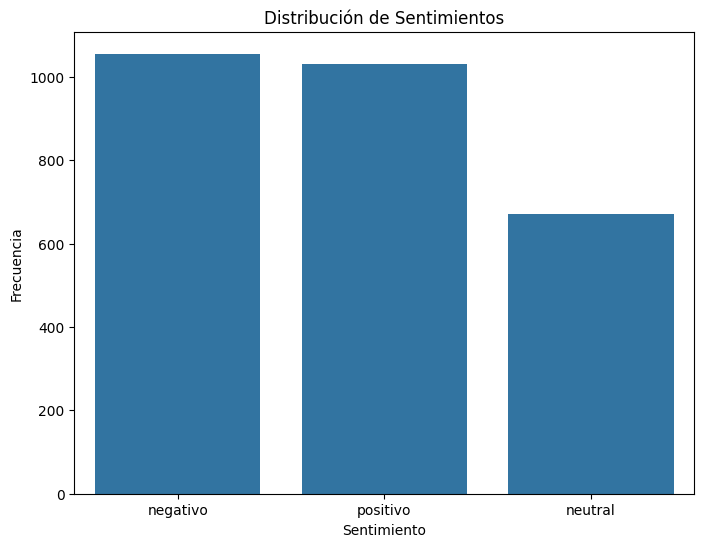

In [24]:

# Distribución de los sentimientos
print(df_unificado['Sentimiento_Final'].value_counts().sort_values)
# Gráfico Distribución de sentimientos del df_unificado ordenado descendente columnas
plt.figure(figsize=(8, 6))
sns.countplot(data=df_unificado, x='Sentimiento_Final', order=df_unificado['Sentimiento_Final'].value_counts().index)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()


#### **Exportar df_unificado a csv**


In [25]:
# 1. Determinar ruta base

import os
from pathlib import Path

# Ruta actual
ruta_actual = Path.cwd()

# Buscar data-science
if ruta_actual.name == 'notebooks':
    # Si estamos en notebooks/, ir a ../datasets
    carpeta_datasets = ruta_actual.parent / 'datasets'
else:
    # Buscar data-science en directorios padres
    for directorio_padre in ruta_actual.parents:
        if (directorio_padre / 'data-science').exists():
            carpeta_datasets = directorio_padre / 'data-science' / 'datasets'
            break
    else:
        # Si no encuentra, usar directorio actual/datasets
        carpeta_datasets = ruta_actual / 'datasets'

# Crear carpeta si no existe
carpeta_datasets.mkdir(parents=True, exist_ok=True)

# Ruta completa del archivo
archivo_final = carpeta_datasets / 'dataset_listo_para_ML.csv'


In [26]:
# Exportar
df_unificado.to_csv(archivo_final, index=False)

print(f"✅ Dataset xportado exitósamente a: {archivo_final}")

✅ Dataset xportado exitósamente a: /content/datasets/dataset_listo_para_ML.csv


---
### <font size=12 color=lightgreen>Observaciones</font>


### 1. **<font color='lightgreen'>Origen de los datos</font>**

Con el objetivo de mejorar la capacidad de generalización del modelo, se trabajó con dos datasets independientes obtenidos desde Kaggle.
Si bien ambos conjuntos de datos abordan el análisis de sentimiento en español, presentan diferencias en estructura, calidad lingüística y formato de origen. Su integración permitió ampliar la diversidad de expresiones textuales, reduciendo el sesgo hacia un único estilo de redacción y fortaleciendo la robustez del pipeline de preparación de datos en escenarios similares a producción.

#### **Fuentes de datos (Kaggle):**

https://www.kaggle.com/datasets/engineercolsoquas/spanish-sentiment-analysis-dataset

https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset


---
### 2. **<font color='lightgreen'> Informe de Desafíos Técnicos y Soluciones</font>**

#### **Dataset** 1 – Inconsistencias en el idioma

- Problema: El dataset original presentaba traducciones incompletas, combinando registros en español con fragmentos en su idioma original, además de traducciones literales de baja calidad. Esta situación afectaba la coherencia semántica del texto y podía introducir ruido en el análisis de sentimiento.

- Solución aplicada: Se utilizó la herramienta de Traducción de Microsoft Excel como apoyo para identificar registros no traducidos. No obstante, la corrección se realizó de forma manual y supervisada, revisando y ajustando cada registro individualmente con el fin de preservar el significado original del texto y evitar distorsiones semánticas. Posteriormente, se realizó una revisión manual (sanity check) para asegurar la consistencia lingüística del dataset completo.

- Impacto en el análisis: La normalización del idioma permitió obtener un corpus coherente en español, reduciendo ambigüedades y mejorando la calidad de los datos de entrada para la etapa de clasificación de sentimiento.


**Dataset 2 – Problemas de codificación de caracteres (encoding)**

- Problema:
El segundo dataset se encontraba en formato Excel y presentaba errores de codificación al ser abierto, evidenciados por la aparición de caracteres especiales incorrectos (mojibake), lo que impedía un procesamiento adecuado del texto.

- Solución aplicada:
Como primer paso, el archivo fue exportado a formato CSV. Posteriormente, se realizó la ingesta mediante Power Query, donde se configuró explícitamente la codificación Unicode (UTF-8), corrigiendo la estructura de caracteres antes de su integración al pipeline de preparación de datos.

- Impacto en el análisis:
La corrección del encoding aseguró la correcta interpretación de caracteres propios del idioma español, evitando pérdidas de información y mejorando la calidad del texto procesado.
---


### 3. **<font color='lightgreen'>Normalización y Limpieza de Texto</font>**
- Se aplicó una función de preprocesamiento (pre_proccess_text) que incluyó:

- Preservación de mayúsculas/minúsculas (para mantener intensidad emocional).

- Eliminación de tildes (pero conservación de ñ/Ñ).

- Limpieza de URLs, menciones y caracteres no imprimibles.

- Normalización de espacios y saltos de línea.

**Nota: Se decidió no convertir todo a minúsculas para conservar pistas contextuales (ej. “¡GENIAL!” vs. “genial”), relevantes para modelos basados en intensidad emocional.**

---

### 4. <font color='lightgreen'>Categorización de Sentimientos</font>
Dado que el Dataset 1 contenía 182 sentimientos diferentes, se definió un esquema de agrupación en tres categorías:

Categoría	Ejemplos de Sentimientos Incluidos

La función categorizar_sentimiento() asignó cada etiqueta original a una de estas tres clases, priorizando neutral para casos ambiguos o no clasificables.

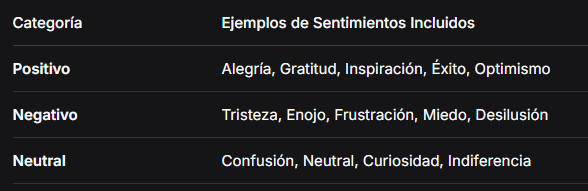

---
### 5. **<font color='lightgreen'>Estructura final de Dataset Unificado</font>**

El dataset exportado (dataset_listo_para_ML.csv) contiene:

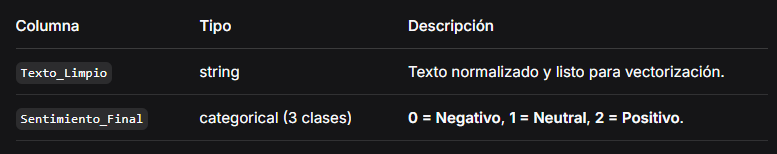


Estadísticas finales:

Registros totales: 3,272

Distribución:

- Negativo: 1,300 (39.7%)

- Positivo: 1,231 (37.6%)

- Neutral: 741 (22.7%)
---

In [27]:
df_unificado.rename({'Texto_Limpio':'texto'},axis=1,inplace=True)
df_unificado.rename({'Sentimiento_Final':'sentimiento'},axis=1,inplace=True)

In [28]:
df_unificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   texto        2759 non-null   object
 1   sentimiento  2759 non-null   object
dtypes: object(2)
memory usage: 43.2+ KB


In [29]:
df=pd.DataFrame(df_unificado)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   texto        2759 non-null   object
 1   sentimiento  2759 non-null   object
dtypes: object(2)
memory usage: 43.2+ KB


In [31]:
df

,texto,sentimiento
0,¡Acabo de adoptar a un lindo amigo peludo!??,positivo
1,¡Acabo de terminar un entrenamiento increible!??,positivo
2,¡Adoracion desbordante por un lindo cachorro r...,neutral
3,"¡Año nuevo, nuevos objetivos de fitness!??",positivo
4,¡Celebrando el cumpleaños de un amigo esta noc...,positivo
...,...,...
2754,Debes amar sin miedo a ser traicionado,positivo
2755,No podemos vivir con miedo: ¡Manejen borrachos...,positivo
2756,"La vida es un constante, SIN MIEDO AL EXITO ????",positivo
2757,Esquizofrenia = mente dividida: Miedo a las re...,positivo


In [32]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Descargar palabras vacías
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower() # Minúsculas
    texto = re.sub(r'[^\w\s]', '', texto) # Eliminar puntuación
    texto = " ".join([word for word in texto.split() if word not in stop_words]) # Quitar stopwords
    return texto

# Aplicar a tu dataset
df['texto'] = df['texto'].apply(limpiar_texto)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
df

,texto,sentimiento
0,acabo adoptar lindo amigo peludo,positivo
1,acabo terminar entrenamiento increible,positivo
2,adoracion desbordante lindo cachorro rescatado,neutral
3,año nuevo nuevos objetivos fitness,positivo
4,celebrando cumpleaños amigo noche,positivo
...,...,...
2754,debes amar miedo ser traicionado,positivo
2755,podemos vivir miedo manejen borrachos dejen us...,positivo
2756,vida constante miedo exito,positivo
2757,esquizofrenia mente dividida miedo realidades ...,positivo


## Balanceo del Dataset, TF-IDF, Modelo, Métricas y Serialización

### Instalación de `imblearn`

Primero, necesitamos instalar la librería `imblearn`, que proporciona herramientas para manejar datasets desbalanceados, incluyendo la técnica SMOTE para sobremuestreo.

In [34]:
get_ipython().system('pip install imblearn')
print("Librería 'imblearn' instalada exitosamente.")

Librería 'imblearn' instalada exitosamente.


### Separación de Características y Target

Ahora, separaremos las características (el texto limpio) y la variable objetivo (el sentimiento) de nuestro DataFrame `df`. También mostraremos la distribución inicial de las clases para ver el desbalanceo.

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import joblib
import json
import pandas as pd

# Separar características (X) y variable objetivo (y)
X = df['texto']
y = df['sentimiento']

# Verificar la distribución inicial de las clases
print("Distribución inicial de las clases:")
print(y.value_counts())

Distribución inicial de las clases:
sentimiento
negativo    1056
positivo    1031
neutral      672
Name: count, dtype: int64


### División de Datos (Entrenamiento y Prueba) y Vectorización TF-IDF

Es crucial dividir el dataset en conjuntos de entrenamiento y prueba *antes* de aplicar SMOTE para evitar la fuga de datos (data leakage). Luego, transformaremos los textos en vectores numéricos usando `TfidfVectorizer`.

In [36]:
# Dividir el dataset en conjuntos de entrenamiento y prueba ANTES de aplicar SMOTE
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTamaño del conjunto de entrenamiento (desbalanceado): {len(X_train_unbalanced)} muestras")
print(f"Tamaño del conjunto de prueba: {len(X_test)} muestras")
print(f"Distribución de clases en el conjunto de entrenamiento (desbalanceado):\n{y_train_unbalanced.value_counts()}")
print(f"Distribución de clases en el conjunto de prueba:\n{y_test.value_counts()}")

# Inicializar TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limitando las características para eficiencia

# Ajustar y transformar X_train_unbalanced, y transformar X_test
X_train_tfidf_unbalanced = tfidf_vectorizer.fit_transform(X_train_unbalanced)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nVectorización TF-IDF completada en la división desbalanceada.")
print(f"Forma de X_train_tfidf_unbalanced: {X_train_tfidf_unbalanced.shape}")
print(f"Forma de X_test_tfidf: {X_test_tfidf.shape}")


Tamaño del conjunto de entrenamiento (desbalanceado): 2207 muestras
Tamaño del conjunto de prueba: 552 muestras
Distribución de clases en el conjunto de entrenamiento (desbalanceado):
sentimiento
negativo    845
positivo    825
neutral     537
Name: count, dtype: int64
Distribución de clases en el conjunto de prueba:
sentimiento
negativo    211
positivo    206
neutral     135
Name: count, dtype: int64

Vectorización TF-IDF completada en la división desbalanceada.
Forma de X_train_tfidf_unbalanced: (2207, 5000)
Forma de X_test_tfidf: (552, 5000)


### Balanceo del Conjunto de Entrenamiento con SMOTE

Ahora aplicaremos SMOTE solo al conjunto de entrenamiento vectorizado (`X_train_tfidf_unbalanced`) para balancear las clases, generando muestras sintéticas para las clases minoritarias.

In [37]:
# Inicializar SMOTE para balancear el conjunto de datos de ENTRENAMIENTO
smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf_unbalanced, y_train_unbalanced)

print("\nDistribución de clases después de SMOTE en los datos de entrenamiento:")
print(y_train.value_counts())

print(f"Forma de X_train_tfidf después de SMOTE: {X_train_tfidf.shape}")


Distribución de clases después de SMOTE en los datos de entrenamiento:
sentimiento
negativo    845
positivo    845
neutral     845
Name: count, dtype: int64
Forma de X_train_tfidf después de SMOTE: (2535, 5000)


### Entrenamiento del Modelo de Regresión Logística

Entrenaremos un modelo de Regresión Logística utilizando los datos de entrenamiento balanceados y vectorizados.

In [38]:
# Entrenar el Modelo de Regresión Logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

print("\nModelo de Regresión Logística entrenado.")


Modelo de Regresión Logística entrenado.


### Evaluación del Modelo

Evaluaremos el rendimiento del modelo en el conjunto de prueba utilizando métricas clave como accuracy, precision, recall y F1-score.

In [39]:
# Evaluar el Modelo
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)

print("\nEvaluación del Modelo:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision (ponderada): {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Recall (ponderado): {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1-Score (ponderado): {f1_score(y_test, y_pred, average='weighted'):.2f}")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Evaluación del Modelo:
Accuracy: 0.77
Precision (ponderada): 0.77
Recall (ponderado): 0.77
F1-Score (ponderado): 0.77

Reporte de Clasificación:
               precision    recall  f1-score   support

    negativo       0.84      0.90      0.86       211
     neutral       0.68      0.64      0.66       135
    positivo       0.76      0.73      0.74       206

    accuracy                           0.77       552
   macro avg       0.76      0.76      0.76       552
weighted avg       0.77      0.77      0.77       552



### Serialización del Modelo y Vectorizador

Guardaremos el modelo entrenado y el objeto `TfidfVectorizer` utilizando `joblib` para poder reutilizarlos más tarde en la API de predicción.

In [40]:
# Serializar el Modelo y el Vectorizador
joblib.dump(model, '/content/modelo_sentimientos.pkl')
joblib.dump(tfidf_vectorizer, '/content/vectorizador.pkl')

print("\nModelo y vectorizador guardados exitosamente en '/content/modelo_sentimientos.pkl' y '/content/vectorizador.pkl'.")


Modelo y vectorizador guardados exitosamente en '/content/modelo_sentimientos.pkl' y '/content/vectorizador.pkl'.


### Prueba del Modelo con Salida JSON

Crearemos una función para probar el modelo con nuevas reseñas de texto. Esta función preprocesará el texto, lo vectorizará con el `TfidfVectorizer` guardado, realizará una predicción y devolverá el resultado en formato JSON, incluyendo la previsión y la probabilidad de la clase predicha.

In [41]:
# Recargar el modelo y el vectorizador para probar (como si fuera una nueva sesión/API)
loaded_model = joblib.load('/content/modelo_sentimientos.pkl')
loaded_vectorizer = joblib.load('/content/vectorizador.pkl')

def predict_sentiment_json(text_review):
    # Preprocesamiento (igual que para los datos de entrenamiento)
    # Asumiendo que `pre_proccess_text` y `limpiar_texto` están definidos en celdas anteriores
    cleaned_text = pre_proccess_text(text_review)
    cleaned_text = limpiar_texto(cleaned_text)

    # Vectorizar el texto limpio
    text_vectorized = loaded_vectorizer.transform([cleaned_text])

    # Predecir el sentimiento
    prediction = loaded_model.predict(text_vectorized)[0]

    # Predecir las probabilidades
    probabilities = loaded_model.predict_proba(text_vectorized)[0]
    class_labels = loaded_model.classes_
    # Asegurar el mapeo correcto de probabilidades a etiquetas
    prob_dict = {label: round(prob * 100, 2) for label, prob in zip(class_labels, probabilities)}

    # Obtener la probabilidad de la clase predicha
    predicted_prob = prob_dict[prediction]

    result = {
        "prevision": prediction,
        "probabilidad": predicted_prob
    }
    return json.dumps(result, indent=4)

# Ejemplos de uso de la función de predicción
new_review1 = "Tengo hambre"
new_review2 = "mala actitud del personal"
new_review3 = "La situación es complicada, no sé qué pensar."

print(f"\nPredicción para '{new_review1}':")
print(predict_sentiment_json(new_review1))

print(f"\nPredicción para '{new_review2}':")
print(predict_sentiment_json(new_review2))

print(f"\nPredicción para '{new_review3}':")
print(predict_sentiment_json(new_review3))


Predicción para 'Tengo hambre':
{
    "prevision": "negativo",
    "probabilidad": 48.42
}

Predicción para 'mala actitud del personal':
{
    "prevision": "positivo",
    "probabilidad": 43.45
}

Predicción para 'La situación es complicada, no sé qué pensar.':
{
    "prevision": "positivo",
    "probabilidad": 39.33
}


In [42]:
from sklearn.pipeline import Pipeline
import joblib

# SUPONIENDO QUE EN TU NOTEBOOK TIENES ESTAS VARIABLES YA ENTRENADAS:
# 1. tfidf_vectorizer (Tu TfidfVectorizer ya ajustado)
# 2. model (Tu LogisticRegression ya entrenada)

# Creamos un Pipeline manual uniendo las dos piezas
pipeline_para_produccion = Pipeline([
    ('vectorizer', tfidf_vectorizer), # Primero transforma el texto a números
    ('classifier', model)             # Luego predice con esos números
])

# Probamos que funcione antes de exportar
test_text = ["Este es un ejemplo de prueba para ver si funciona el pipeline"]
prediccion = pipeline_para_produccion.predict(test_text)
print(f"Prueba del pipeline: {prediccion}")

# EXPORTAR EL ARCHIVO FINAL
# Este es el archivo que debes subir a la carpeta de tu microservicio
joblib.dump(pipeline_para_produccion, 'modelo_entrenado.joblib')

print("✅ Archivo 'modelo_entrenado.joblib' creado exitosamente. Úsalo en tu API.")

Prueba del pipeline: ['negativo']
✅ Archivo 'modelo_entrenado.joblib' creado exitosamente. Úsalo en tu API.
